**Importing the Required Libraries**

In [118]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt 
import geopy.distance

In [119]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [120]:
train = train.drop_duplicates()
test = test.drop_duplicates()

<font color="purple">
Look for any Null values
</font>

In [121]:
train.isna().sum()
#No Null values in any cell

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
dtype: int64

In [122]:
test.isna().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
dtype: int64

<font color="purple">
Convert any categorical attributes to lower case and do one  encoding
</font>

In [123]:
#one-hot encode 'region'
train = pd.get_dummies(train, columns=['region'])
train.to_csv('train_modified.csv',index=False)


test = pd.get_dummies(test, columns=['region'])
test.to_csv('test_modified.csv',index=False)


<font color="purple">
These are the Datafields with Categorical Attributes:

town - 'town' & 'planning_area' values are same for ~58K dataset(need to recheck the value) , hence dropped 'town' atrribute
    
block - Values are dropped as ~2K different values are present
    
street_name - Values are dopped as ~1.8K differnt values are present
    
flat_type - merged with flat_model
    
flat_model - (One-hot encoded) ~39 unique values after merging, but 3 extra values in train compared to test set, hence those extra records which are ~12 are dropped
    
furnished - Dropped, as the value is same accross all the records
    
elevation - Dropped, as the value is same accross all the records
    
subszone & planning_area are combined into one record, as the merged records unique values=152 same as unique values for subzones. These records are 'target encoded' as One-hot encoding for 152 records is not a good idea keeping dimensionality in mind
 
region - This is one-hot encoded

Lease Commencement date and Rent date :

Using these two parameters , flat-age is calculated
    
Note: 
1. No values are rounded of to nearest integer
</font>

In [124]:
#Drop furnished,elevation columns as the values are same for all the records
#Also dropping block,street_name and town. (as the number of values in town is same as planning_area,hence dropped it)
train = train.drop(['furnished','elevation','block','street_name','town'],axis=1)
train.to_csv('train_modified.csv',index=False)

test = test.drop(['furnished','elevation','block','street_name','town'],axis=1)
test.to_csv('test_modified.csv',index=False)

In [125]:
train['Combined_zone'] = train['subzone'] + '-' + train['planning_area']
train = train.drop(['subzone','planning_area'],axis=1)
train.to_csv('train_modified.csv',index=False)

test['Combined_zone'] = test['subzone'] + '-' + test['planning_area']
test = test.drop(['subzone','planning_area'],axis=1)
test.to_csv('test_modified.csv',index=False)

#Checking if there are any missing values from train to test
unique_values_train = set(train['Combined_zone'].unique())
unique_values_test = set(test['Combined_zone'].unique())
values_only_in_train = unique_values_train - unique_values_test
print(values_only_in_train)

set()


In [126]:
#Converting categorical attributes to lowercase wherever there are discripencies in the formats
categorical_columns = ['flat_model']
train[categorical_columns] = train[categorical_columns].apply(lambda x: x.str.lower())
test[categorical_columns] = test[categorical_columns].apply(lambda x: x.str.lower())

#flat-type attribute has discripencies like 2 room and 2-room , replaced ' ' with '-'
train['flat_type'] = train['flat_type'].str.replace(' ', '-')
test['flat_type'] = test['flat_type'].str.replace(' ', '-')

train['Combined_flat_type'] = train['flat_type'] + '-' + train['flat_model']
train.to_csv('train_modified.csv',index=False)


test['Combined_flat_type'] = test['flat_type'] + '-' + test['flat_model']
test.to_csv('test_modified.csv',index=False)

#Checking if there are any missing values from train to test
unique_values_train = set(train['Combined_flat_type'].unique())
unique_values_test = set(test['Combined_flat_type'].unique())
values_only_in_train = unique_values_train - unique_values_test
print(values_only_in_train)

#There are records with values not present in the test data , but present in the train data , hence these can be removed
values_to_drop = ['5-room-3gen', '2-room-premium apartment', '4-room-terrace']
train = train[~train['Combined_flat_type'].isin(values_to_drop)]
print(len(train['Combined_flat_type'].isin(values_to_drop)))
train.to_csv('train_modified.csv',index=False)



{'5-room-3gen', '2-room-premium apartment', '4-room-terrace'}
59715


<font color="purple">
~12 records are dropped in training set , as the {'5-room-3gen', '2-room-premium apartment', '4-room-terrace'} are not present in test set
</font>

In [127]:
#Checking for unique values between both the test data and the train data

unique_values_train = set(train['Combined_zone'].unique())
unique_values_test = set(test['Combined_zone'].unique())

# Find the values that exist in one dataset but not in the other
values_only_in_train = unique_values_train - unique_values_test
print(values_only_in_train)

set()


In [128]:
#formatted rent_approval_date and lease to yy-mm-dd format
train['rent_approval_date'] = pd.to_datetime(train['rent_approval_date'] + '-01')
train['lease_commence_date'] = pd.to_datetime(train['lease_commence_date'].astype(str) + '-01', format='%Y-%m-%d')
train['flat_age'] = ((train['rent_approval_date'] - train['lease_commence_date']).dt.days / 365.0)
train.to_csv('train_modified.csv',index=False)

test['rent_approval_date'] = pd.to_datetime(test['rent_approval_date'] + '-01')
test['lease_commence_date'] = pd.to_datetime(test['lease_commence_date'].astype(str) + '-01', format='%Y-%m-%d')
test['flat_age'] = ((train['rent_approval_date'] - test['lease_commence_date']).dt.days / 365.0)
test.to_csv('test_modified.csv',index=False)

<font color="purple">
    Now drop the attributes 'rent_approval_date' and 'lease_commence_date' as the flat_age is calculated
</font>

In [129]:
train = train.drop(['rent_approval_date','lease_commence_date'],axis=1)
train.to_csv('train_modified.csv',index=False)

test = test.drop(['rent_approval_date','lease_commence_date'],axis=1)
test.to_csv('test_modified.csv',index=False)

In [130]:
'''Target encode Combined_zone as the number of unique values for Combined zone which is (subzone + planning_area) 
has nearly 152 unique values'''

Combined_zone_map = train.groupby('Combined_zone')['monthly_rent'].mean().to_dict()
train['Combined_zone'] = train['Combined_zone'].map(Combined_zone_map)
train.to_csv('train_modified.csv',index=False)

test['Combined_zone'] = test['Combined_zone'].map(Combined_zone_map)
test.to_csv('test_modified.csv',index=False)

In [131]:
#Number of unique values in combined flat type
len(train['Combined_flat_type'].unique())

36

In [132]:
train = pd.get_dummies(train, columns=['Combined_flat_type'])
train.to_csv('train_modified.csv',index=False)

test = pd.get_dummies(test, columns=['Combined_flat_type'])
test.to_csv('test_modified.csv',index=False)

In [133]:
#Drop flat_type and flat_model attributes as combined_flat_type is created

train = train.drop(['flat_type','flat_model'],axis=1)
train.to_csv('train_modified.csv',index=False)
test = test.drop(['flat_type','flat_model'],axis=1)
test.to_csv('test_modified.csv',index=False)

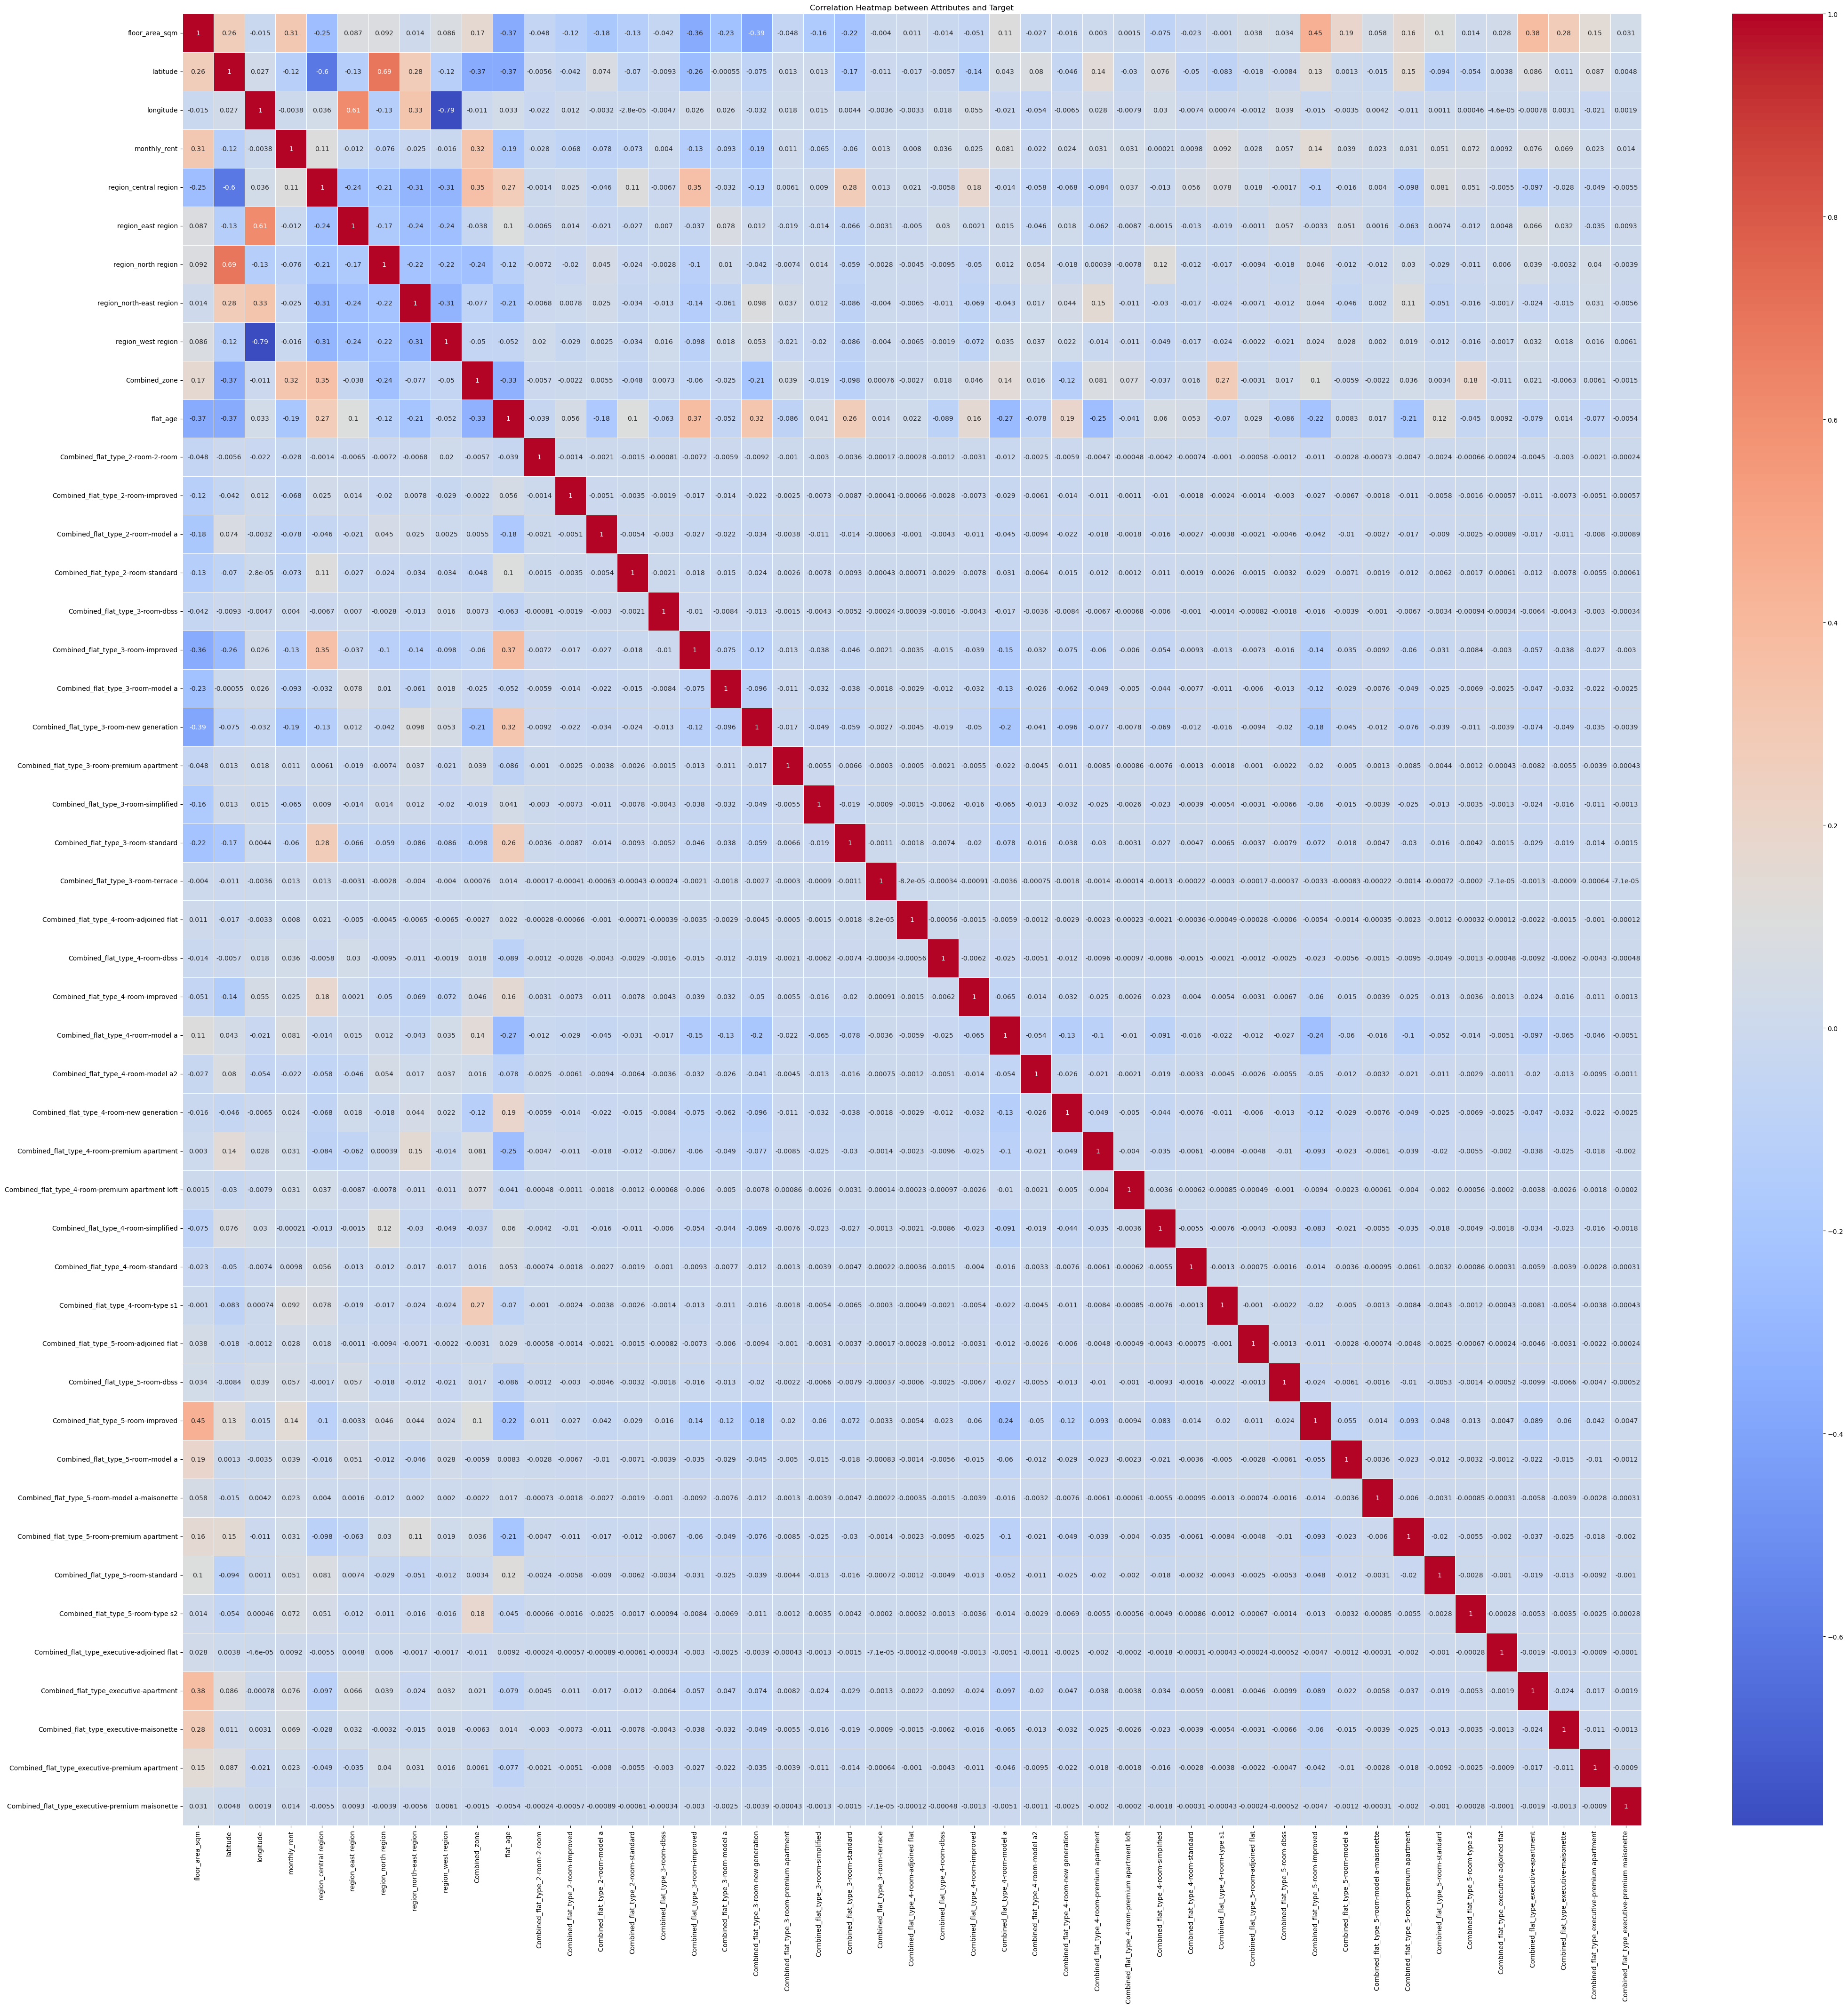

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#selected_columns = train.drop(columns=['monthly_rent'])
corr_matrix = train.corr()
# Create a heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap between Attributes and Target")
plt.show()

In [191]:
#Find distances given lat and long
df_modified = pd.read_csv('train_modified.csv')
df_school = pd.read_csv('auxiliary-data/sg-primary-schools.csv')


#df_modified['coordinates'] = list(zip(df_modified['latitude'], df_modified['longitude']))
#df_modified.to_csv('train_modified.csv',index=False)

#calculating nearest school distance from a given flat
#df_school['school_coordinates'] = list(zip(df_school['latitude'], df_school['longitude']))
#df_school.to_csv('auxiliary-data/sg-primary-schools.csv',index=False)

In [174]:
def calculate_distance(target_df, auxiliary_df, target_csv, target_colname):
    nearest_school_distances = []

    # Iterate through each flat
    for _, target_row in target_df.iterrows():
        target_coords = (target_row['latitude'], target_row['longitude'])

        # Initialize variables to store the minimum distance and nearest school
        min_distance = float('inf')

        # Iterate through each school to find the minimum distance
        for _, auxiliary_row in auxiliary_df.iterrows():
            auxiliary_coords = (auxiliary_row['latitude'], auxiliary_row['longitude'])
            distance = geopy.distance.geodesic(target_coords, auxiliary_coords).km

            if distance < min_distance:
                min_distance = distance

        # Append the minimum distance to the list
        nearest_school_distances.append(min_distance)

    # Add a new column 'nearest_School' to the flat DataFrame
    target_df[target_colname] = nearest_school_distances

    # Save the updated flat DataFrame with the nearest school distances
    target_df.to_csv(target_csv, index=False)



In [194]:
import numpy as np
def calculate_distance(target_df, auxiliary_df, target_csv, target_colname):
    # Convert latitude and longitude columns to NumPy arrays
    target_coords = target_df[['latitude', 'longitude']].to_numpy()
    auxiliary_coords = auxiliary_df[['latitude', 'longitude']].to_numpy()

    # Calculate pairwise distances using the Haversine formula
    distances = np.zeros((len(target_coords), len(auxiliary_coords)))
    
    for i, target_coord in enumerate(target_coords):
        for j, auxiliary_coord in enumerate(auxiliary_coords):
            distances[i, j] = geopy.distance.geodesic(target_coord, auxiliary_coord).km

    # Find the minimum distance for each flat
    nearest_distances = np.min(distances, axis=1)

    # Add a new column 'nearest_School' to the flat DataFrame
    target_df[target_colname] = nearest_distances

    # Save the updated flat DataFrame with the nearest school distances
    target_df.to_csv(target_csv, index=False)


In [193]:
#geopy.distance.geodesic((1.34451804267549,103.738630332612),(1.34451804267549,103.738630332612)).km
df_shopping = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
calculate_distance(df_modified, df_shopping, 'train_modified.csv', 'nearest_Shopping')

In [ ]:
calculate_distance(df_modified, df_school, 'train_modified.csv', 'nearest_School')